In [ ]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import re
import pickle
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD
from tqdm import tqdm
import seaborn as sns
# from sparse import COO

# Download the pickle file

In [ ]:
def load_pickle(path):
    with open(path,'rb') as f:
        return pickle.load(f)

In [ ]:
# eg train_data['proteins'][32][3] 
# here for the second index 32 is the no.32 protein, 
#for the last index, 0 is X_list, 1 is Y_lis,2 is Z_lis, 3 is the atom_list  
train_data=load_pickle('/content/drive/MyDrive/BS6207/Project/training_data.pkl')
test_data=load_pickle('/content/drive/MyDrive/BS6207/Project/training_data.pkl')

In [ ]:
# Define location visulazation function
def visulazation(protein,ligand):
    '''
    Plots a 3D plot to visualize the protein-ligand pairing
    '''  
    plt.rcParams['figure.figsize'] = (16,10)
    fig = plt.figure() 
    sns.set(style = "darkgrid")

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(protein[0], protein[1], protein[2], c='r', marker='o')
    ax.scatter(ligand[0], ligand[1], ligand[2], c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [ ]:
len(train_data['proteins'][0][0])

701

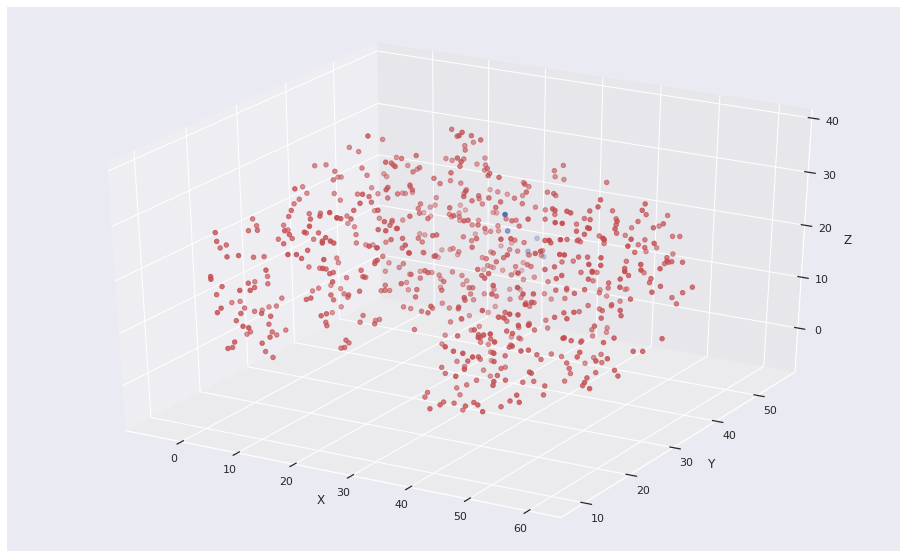

In [ ]:
visulazation(train_data['proteins'][0],train_data['ligands'][0])

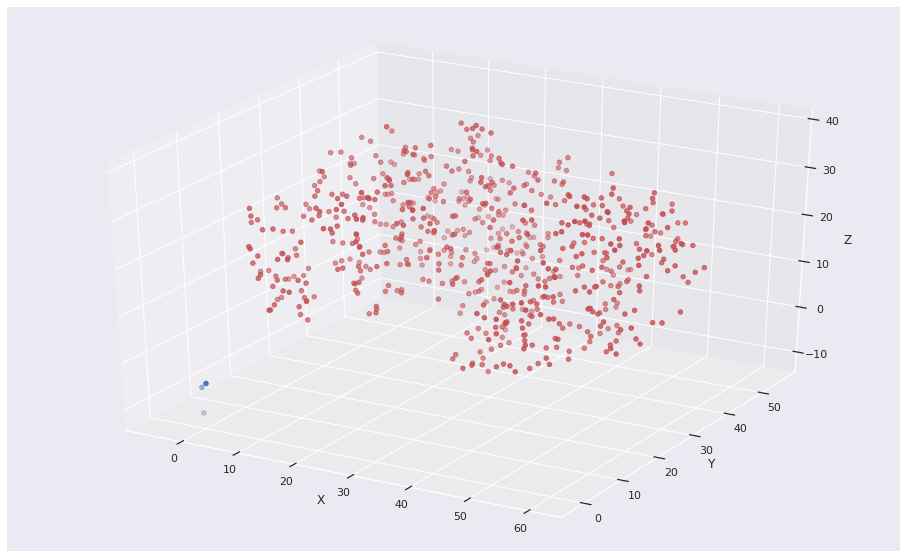

In [ ]:
visulazation(train_data['proteins'][0],train_data['ligands'][9])

# Pre-processing

## Scale

In [ ]:
# Move the whole cube to the center. The center is mean of the centers of 'ligands'
scaled_data = {
    'proteins': list(),
    'ligands': list()
}
for i in range(len(train_data['proteins'])):
  mean_center = np.expand_dims(np.mean(train_data['ligands'][i][:3],axis = 1),axis = 1)
  temp_pro = np.array(train_data['proteins'][i][:3]) - mean_center
  scaled_data['proteins'].append([temp_pro,train_data['proteins'][i][3]])
  temp_gli = np.array(train_data['ligands'][i][:3]) - mean_center
  scaled_data['ligands'].append([temp_gli,train_data['ligands'][i][3]])

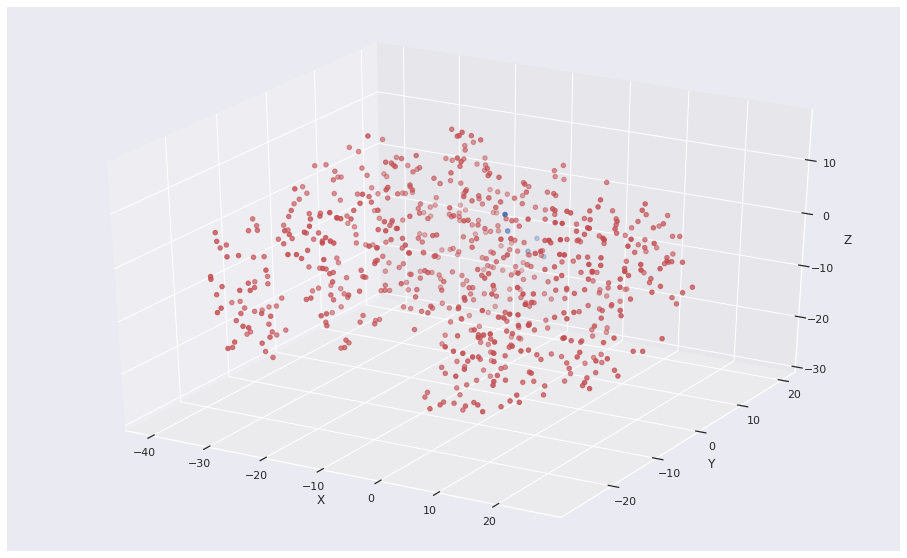

In [ ]:
visulazation(scaled_data['proteins'][0][0],scaled_data['ligands'][0][0])

## Check the cube **size**

In [ ]:
lis =[]
lis.append(max(abs(scaled_data['ligands'][0][0][0])))

In [ ]:
# Record the maximum size of each asix to estimate the size of cube
x_max = []
y_max = []
z_max = []
for i in range(len(train_data['proteins'])):
  x_max.append(max(abs(scaled_data['proteins'][i][0][0])))
  y_max.append(max(abs(scaled_data['proteins'][i][0][1])))
  z_max.append(max(abs(scaled_data['proteins'][i][0][2])))

In [ ]:
max_size = pd.DataFrame({'x_max':x_max,'y_max':y_max,'z_max':z_max})
max_size

,x_max,y_max,z_max
0,40.017200,27.598000,27.823200
1,27.905800,24.188400,40.702600
2,44.876500,30.216667,18.821833
3,39.691000,63.738200,34.239800
4,25.510667,32.833167,41.122667
...,...,...,...
2995,72.800333,35.399000,73.310667
2996,23.742000,33.079000,36.219000
2997,25.683000,30.807000,31.641500
2998,43.254667,33.245667,41.397333


In [ ]:
max_size.describe()

,x_max,y_max,z_max
count,3000.000000,3000.000000,3000.000000
mean,39.992333,40.369753,42.849592
std,18.789355,19.764223,21.467783
min,8.642429,10.115857,10.379714
25%,27.067038,27.489500,28.384525
50%,34.487250,34.577167,36.072083
75%,47.492777,47.796625,50.304625
max,282.239667,261.038600,271.938000


# Generate cubes

## Positive_pairing cube

In [88]:
def positive_cubes_downsampling(cubes_size, scaled_data,n):
  # in order to convert to tensor the datatype should be float32
  cube = np.zeros((2,cubes_size,cubes_size,cubes_size),dtype=np.float32)
  cubes = []
  # the oringal size of cubes should be 100 * 100 * 100
  ratio = 100/cubes_size
  shiftL = (cubes_size - 1 ) // 2
  discard_num = [0,0]
  overlap_num = [0,0]
  # protein:
  for i in range(n):
     # ligands:  
    for k in range(len(scaled_data['ligands'][i][0][0])):
      x_l, y_l,z_l = scaled_data['ligands'][i][0][0][k],scaled_data['ligands'][i][0][1][k],scaled_data['ligands'][i][0][2][k]
      x_l, y_l,z_l = int(x_l/ratio + shiftL),int(y_l/ratio + shiftL),int(z_l/ratio + shiftL)
      if x_l >= cubes_size or  y_l >= cubes_size or z_l >= cubes_size or x_l < 0 or  y_l < 0 or z_l < 0 :
        discard_num[1] += 1
        continue
      if cube[0,x_l, y_l,z_l] !=0 or cube[1,x_l, y_l,z_l] !=0:
        overlap_num[1] += 1
        continue
      # first channel
      cube[0,x_l, y_l,z_l] = 1
      # second channel
      if scaled_data['ligands'][i][1][k] == 'h':
        cube[1,x_l, y_l,z_l] = 1
      else:
        cube[1,x_l, y_l,z_l] = -1
    # protein:
    for j in range(len(scaled_data['proteins'][i][0][0])):
      x_p, y_p,z_p = scaled_data['proteins'][i][0][0][j],scaled_data['proteins'][i][0][1][j],scaled_data['proteins'][i][0][2][j]
      # and convert the data type of (x,y,z) into int
      x_p, y_p,z_p = int(x_p/ratio + shiftL),int(y_p/ratio + shiftL),int(z_p/ratio + shiftL)
      # crop the cube 
      if x_p >= cubes_size or  y_p >= cubes_size or z_p >= cubes_size or x_p < 0 or  y_p < 0 or z_p < 0 :
        discard_num[0] += 1
        continue
      # check the overlaping atoms
      if cube[0,x_p, y_p,z_p] !=0 or cube[1,x_p, y_p,z_p] !=0:
        overlap_num[0] += 1
        continue
      # first channel
      cube[0,x_p, y_p,z_p] = -1
      # second channel
      if scaled_data['proteins'][i][1][j] == 'h':
        cube[1,x_p, y_p,z_p] = 1
      else:
        cube[1,x_p, y_p,z_p] = -1
    cubes.append(cube)
  return np.array(cubes,dtype=np.float32),  discard_num, overlap_num

In [89]:
positive_cubes,  discard_num, overlap_num = positive_cubes_downsampling(25, scaled_data,3000)

In [90]:
positive_cubes.shape

(3000, 2, 25, 25, 25)

In [91]:
positive_cubes.dtype

dtype('float32')

In [92]:
discard_num

[638597, 0]

In [93]:
overlap_num

[3233231, 13759]

## Negative pairing cube

In [94]:
import random
def neg_cubes_building(cubes_size, scaled_data,n):
  cube = np.zeros((2,cubes_size,cubes_size,cubes_size),dtype=np.float32)
  cubes = []
  # the oringal size of cubes should be 100 * 100 * 100
  ratio = 100/cubes_size
  shiftL = (cubes_size - 1 ) // 2
  discard_num = [0,0]
  overlap_num = [0,0]
  # protein:
  for i in range(n):
    # ligands:  
     # random select a 'ligands'
    ii = random.randint(0,n-1)
    for k in range(len(scaled_data['ligands'][ii][0][0])):
      x_l, y_l,z_l = scaled_data['ligands'][ii][0][0][k],scaled_data['ligands'][ii][0][1][k],scaled_data['ligands'][ii][0][2][k]
      x_l, y_l,z_l = int(x_l/ratio + shiftL),int(y_l/ratio + shiftL),int(z_l/ratio + shiftL)
      if x_l >= cubes_size or  y_l >= cubes_size or z_l >= cubes_size or x_l < 0 or  y_l < 0 or z_l < 0 :
        discard_num[1] += 1
        continue
      if cube[0,x_l, y_l,z_l] !=0 or cube[1,x_l, y_l,z_l] !=0:
        overlap_num[1] += 1
        continue
      # first channel
      cube[0,x_l, y_l,z_l] = 1
      # second channel
      if scaled_data['ligands'][ii][1][k] == 'h':
        cube[1,x_l, y_l,z_l] = 1
      else:
        cube[1,x_l, y_l,z_l] = -1
    # protein:
    for j in range(len(scaled_data['proteins'][i][0][0])):
      x_p, y_p,z_p = scaled_data['proteins'][i][0][0][j],scaled_data['proteins'][i][0][1][j],scaled_data['proteins'][i][0][2][j]
      # Shift all the atoms by 25 such that the center could be 25,25,25
      # and convert the data type of (x,y,z) into int
      x_p, y_p,z_p = int(x_p/ratio + shiftL),int(y_p/ratio + shiftL),int(z_p/ratio + shiftL)
      # crop the cube size with 50*50*50
      if x_p >= cubes_size or  y_p >= cubes_size or z_p >= cubes_size or x_p < 0 or  y_p < 0 or z_p < 0 :
        discard_num[0] += 1
        continue
      # check the overlaping atoms
      if cube[0,x_p, y_p,z_p] !=0 or cube[1,x_p, y_p,z_p] !=0:
        overlap_num[0] += 1
        continue
      # first channel
      cube[0,x_p, y_p,z_p] = -1
      # second channel
      if scaled_data['proteins'][i][1][j] == 'h':
        cube[1,x_p, y_p,z_p] = 1
      else:
        cube[1,x_p, y_p,z_p] = -1
    
    cubes.append(cube)
  return np.array(cubes,dtype=np.float32)

In [95]:
negetive_cube = neg_cubes_building(25,scaled_data,3000)

In [96]:
negetive_cube.shape

(3000, 2, 25, 25, 25)

# Training process

## Split Data into Training and Validation
- 6000 cubes in total  (3000 positive pairs/3000 negative pairs)
- 80% traing_data  (4800 samples of protein-ligand pairs)
- 20% validation_data (1200 samples of protein-ligand pairs)


In [139]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

In [140]:
# split data set and generate shuffled index
train_set = np.append(positive_cubes,negetive_cube,axis=0)
train_y = np.array([1] * 3000 + [0] * 3000)
dataset_size = len(train_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [141]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [142]:
class cube_Dataset(Dataset):
    def __init__(self, cube_data,cube_label):
        self.cube_data = cube_data
        self.cube_label = cube_label
    def __len__(self):
        return len(self.cube_data)
    
    def __getitem__(self, index):
        cube = self.cube_data[index]
        # cube = cube.resize((128,128))
        label = self.cube_label[index]
        return cube, label

In [143]:
train_dataset = cube_Dataset(train_set,train_y)

In [144]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## Define CNN 

### CNN3

In [145]:
class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv3d(2,64,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv3d(64, 128,kernel_size=3,stride=1, padding=0)
        self.conv3 = nn.Conv3d(128, 256,kernel_size=3,stride=1, padding=0)
        self.pool = nn.MaxPool3d(2, 2)
        self.dropout = nn.Dropout3d(0.4)
        self.batchnorm1 = nn.BatchNorm3d(64)
        self.batchnorm2 = nn.BatchNorm3d(128)
        self.batchnorm3 = nn.BatchNorm3d(256)
        self.fc1 = nn.Linear(256*1*1*1,1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchnorm2(self.pool(F.relu(self.conv2(x))))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1) # Flatten layer
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [146]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv3d(2,32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv3d(32, 64,kernel_size=3,stride=1, padding=0)
        self.pool = nn.MaxPool3d(2, 2)
        self.dropout = nn.Dropout3d(0.4)
        self.batchnorm1 = nn.BatchNorm3d(32)
        self.batchnorm2 = nn.BatchNorm3d(64)
        self.fc1 = nn.Linear(64*4*4*4,1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchnorm2(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(x)
        # print(x.shape)
        x = x.view(x.size(0), -1) # Flatten layer
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

##Train

In [147]:
model = CNN_3()
print(model)

CNN_3(
  (conv1): Conv3d(2, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout3d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [148]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [149]:
def train_model(n_epochs,lr,w_decay,model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay = w_decay,)
  valid_loss_min = np.Inf
  val_loss = []
  val_acc = [0]
  train_loss = []
  train_acc = []
  total_step = len(train_loader)
  for epoch in range(1, n_epochs + 1):
      running_loss = 0.0
      # scheduler.step(epoch)
      correct = 0
      total=0
      for batch_idx, (data_, target_) in enumerate(train_loader):
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = model(data_)
          loss = criterion(outputs, target_)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          _,pred = torch.max(outputs, dim=1)
          correct += torch.sum(pred==target_).item()
          total += target_.size(0)
          if (batch_idx) % 20 == 0:
              print ('------------Epoch [{}/{}]----------- Loss: {:.4f}' 
                    .format(epoch, n_epochs, loss.item()))
      train_acc.append(100 * correct / total)
      train_loss.append(running_loss/total_step)
      print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
      batch_loss = 0
      total_t=0
      correct_t=0
      with torch.no_grad():
          model.eval()
          for data_t, target_t in (validation_loader):
              #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
              outputs_t = model(data_t)
              loss_t = criterion(outputs_t, target_t)
              batch_loss += loss_t.item()
              _,pred_t = torch.max(outputs_t, dim=1)
              correct_t += torch.sum(pred_t==target_t).item()
              total_t += target_t.size(0)
          # if (100 * correct_t / total_t) == val_acc[-1]:
          #   return train_acc,val_acc
          val_acc.append(100 * correct_t / total_t)
          val_loss.append(batch_loss/len(validation_loader))
          network_learned = batch_loss < valid_loss_min
          print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
      model.train()
  return train_acc,val_acc

In [150]:
train_acc,val_acc  = train_model(10,0.001,0,model)

------------Epoch [1/10]----------- Loss: 1.3687
------------Epoch [1/10]----------- Loss: 0.0000
------------Epoch [1/10]----------- Loss: 0.0000
------------Epoch [1/10]----------- Loss: 0.0000

train loss: 0.0231, train acc: 99.1250
validation loss: 0.0000, validation acc: 100.0000

------------Epoch [2/10]----------- Loss: 0.0000
------------Epoch [2/10]----------- Loss: 0.0000
------------Epoch [2/10]----------- Loss: 0.0000
------------Epoch [2/10]----------- Loss: 0.0000

train loss: 0.0116, train acc: 100.0000
validation loss: 0.0000, validation acc: 100.0000

------------Epoch [3/10]----------- Loss: 0.0000
------------Epoch [3/10]----------- Loss: 0.0000
------------Epoch [3/10]----------- Loss: 0.0000
------------Epoch [3/10]----------- Loss: 0.0000

train loss: 0.0077, train acc: 100.0000
validation loss: 0.0000, validation acc: 100.0000

------------Epoch [4/10]----------- Loss: 0.0000
------------Epoch [4/10]----------- Loss: 0.0000
------------Epoch [4/10]----------- Los